In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Implement Action-history-dependent Learning Algorithm

In [2]:
# Problem data.
# Input: n, d1,...,dm

# m is the number of variables
m = 4

# n is the number of time steps
# (constraints that are revealed one by one)
n = 2000 

d = np.full(m, 0.5)

In [3]:
# Make results deterministic for debugging
np.random.seed(23)

In [4]:
# Runs Algorithm 3 in paper [5]
def run_alg_3(n, m, d):
    start = time.time()
    
    A = np.random.uniform(0, 1, (m, n))
    pi = np.random.uniform(0, 1, n)

    # Initialize the constraint b_i0 = n d_i for i=1,...,m
    b = n*d

    historical_b = np.zeros((n,m))
    historical_b[0] = b

    # Initialize the dual price p1 = 0

    p = np.zeros((m,))

    historical_p = np.zeros((n,m))
    historical_p[0] = p

    # Initialize x vector
    x = np.ndarray(0)

    ############################################################

    # For t=1,...,n do
    for t in range(1,n):
        if t % 500 == 0:
            now = time.time()
            print("%d iterations completed in %.2f s" % (t, now-start))
        
        #print("\nIteration %d" % (t))
        # Observe (pi_t, a_t)
        a_t = A[:,t-1]
        pi_t = pi[t-1]
        #print("a_t: %s" % (a_t))
        #print("pi_t: %s" % (pi_t))

        # Set:
        # x_t = 1 if r_t > a_t' p_t
        # x_t = 0 if r_t <=  a_t' p_t
        # Save values of x into array
        xt = 0
        if pi_t > np.transpose(a_t)@historical_p[t-1]:
            xt = 1
        x = np.append(x, xt)
        #print("x: %s" % (x))

        # Update the constraint vector
        b = historical_b[t-1] - np.array(a_t*xt).flatten()
        historical_b[t] = b
        #print("b: %s" % (b))

        # Specify a primal optimization problem
        # max sum from j=1 to t of r_j x_j
        # such that sum from j=1 to t of a_ij x_j <= tb_{it} / (n-t) for i=1,...,m
        # 0<=xj<=1 for j=1,...,t

        # Define variables
        a_up_to_t = A[:,:t]
        pi_up_to_t = pi[:t]
        x_opt = cp.Variable(t)

        # Create constraints.
        constraints = [a_up_to_t @ x_opt <= t*b / (n-t),
                       x_opt >= 0,
                       x_opt <= 1]

        # Form objective.
        obj = cp.Maximize(pi_up_to_t @ x_opt)

        # Form and solve problem.
        prob = cp.Problem(obj, constraints)
        prob.solve()

        # The optimal dual variable (Lagrange multiplier) for
        # a constraint is stored in constraint.dual_value.
        #print("optimal (a_up_to_t @ x_opt <= t*b / (n-t)) dual variable", constraints[0].dual_value)

        p = constraints[0].dual_value

        historical_p[t] = p

    return historical_b

## Recreate Figure 1 in Paper [5]

In [5]:
def get_binding_constraint_to_plot(historical_b):
    index_of_binding_constraint = np.argmin(historical_b[-1])

    return historical_b[:,index_of_binding_constraint]

In [6]:
num_trials = 10

In [7]:
trial_num_to_to_plot = dict()
for i in range(num_trials):
    print("Trial %d" % (i))
    hist_b = run_alg_3(n, m, d)
    trial_num_to_to_plot[i] = get_binding_constraint_to_plot(hist_b)

Trial 0
500 iterations completed in 3.70 s
1000 iterations completed in 9.26 s
1500 iterations completed in 17.43 s
Trial 1
500 iterations completed in 3.61 s
1000 iterations completed in 8.72 s
1500 iterations completed in 16.53 s
Trial 2
500 iterations completed in 3.61 s
1000 iterations completed in 9.47 s
1500 iterations completed in 18.34 s
Trial 3
500 iterations completed in 3.62 s
1000 iterations completed in 9.44 s
1500 iterations completed in 18.19 s
Trial 4
500 iterations completed in 3.96 s
1000 iterations completed in 9.63 s
1500 iterations completed in 17.63 s
Trial 5
500 iterations completed in 3.69 s
1000 iterations completed in 9.32 s
1500 iterations completed in 17.87 s
Trial 6
500 iterations completed in 3.30 s
1000 iterations completed in 8.34 s
1500 iterations completed in 15.45 s
Trial 7
500 iterations completed in 3.48 s
1000 iterations completed in 8.88 s
1500 iterations completed in 16.26 s
Trial 8
500 iterations completed in 3.29 s
1000 iterations completed in 

In [8]:
x = np.arange(0, 2000)

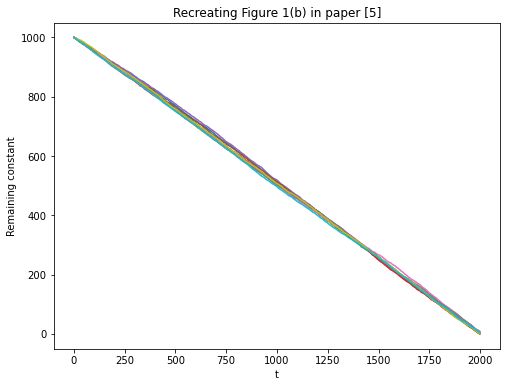

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

for i in range(num_trials):
    plt.plot(x, trial_num_to_to_plot[i])
plt.xlabel("t")
plt.ylabel("Remaining constant")
plt.title("Recreating Figure 1(b) in paper [5]")
plt.show()

    

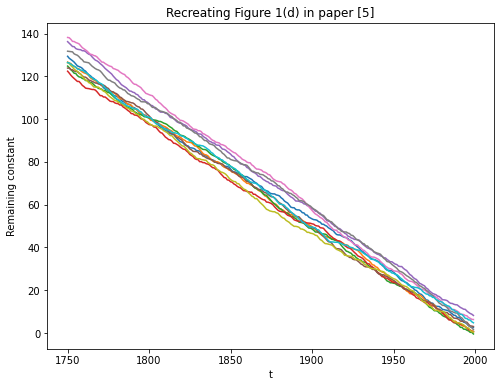

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

for i in range(num_trials):
    plt.plot(x[1750:], trial_num_to_to_plot[i][1750:])
plt.xlabel("t")
plt.ylabel("Remaining constant")
plt.title("Recreating Figure 1(d) in paper [5]")
plt.show()

## Use the setting of Random Input I to assess stopping time and remaining inventory B_n